In [235]:
#Import packages
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
sys.path.append('./molecular-state-classes-and-functions/')
from classes import UncoupledBasisState, CoupledBasisState, State
from functions import make_hamiltonian, make_hamiltonian_B, make_QN, ni_range, vector_to_state, matrix_to_states
from functions import find_state_idx_from_state
import pickle
from OBE_functions import *
import scipy

import matplotlib.pyplot as plt
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## X-state Hamiltonian
Load the X-state hamiltonian from file and transform it to the coupled basis

In [236]:
H_X_uc = make_hamiltonian("./utilities/TlF_X_state_hamiltonian_J0to4.pickle")

In [237]:
#Generate lists of quantum numbers
QN_X_uncoupled = make_QN(0,3,1/2,1/2)

Jmin = 0
Jmax = 4
I_F = 1/2
I_Tl = 1/2
QN_X = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
     ]

In [238]:
### Transform Hamiltonian to coupled basis ###
#Load transform matrix
with open("./utilities/UC_to_C_j0to4.pickle","rb") as f:
    S_trans = pickle.load(f)

In [239]:
#Transform matrix
E = np.array((0,0,0))
B = np.array((0,0,0.001))
H_X =  S_trans.conj().T @ H_X_uc(E, B) @ S_trans

In [240]:
D, V = np.linalg.eigh(H_X)

#Diagonalize the Hamiltonian
H_X_diag = V.conj().T @ H_X @ V

#New set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

state = vector_to_state(V[:,1],QN_X)
state.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


In [241]:
QN_X_diag[-1].print_state()

+1.0000-0.0000j x |X, J = 4, F1 = 9/2, F = 5, mF = -5, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


Find the part of the Hamiltonian that is used for the simulations

In [242]:
#Define what states are to be included in the simulation
Js = [0,2]
ground_states = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

ground_states_diag = []
for ground_state in ground_states:
    i = find_state_idx_from_state(H_X_diag,ground_state, QN_X_diag)
    ground_states_diag.append(QN_X_diag[i])

In [243]:
H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states_diag)

In [244]:
H_X_red.shape

(24, 24)

In [245]:
ground_states_diag[-1].print_state()

+1.0000+0.0000j x |X, J = 2, F1 = 5/2, F = 3, mF = 3, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


## B-state Hamiltonian

In [246]:
H_B = make_hamiltonian_B("./utilities/B_hamiltonians_symbolic_coupled_P_1to3.pickle")

In [247]:
Jmin = 1
Jmax = 3
I_F = 1/2
I_Tl = 1/2
Ps = [-1, 1]
QN_B = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B')
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
      for P in Ps
     ]

In [248]:
D,V = np.linalg.eigh(H_B)

#Diagonalize the Hamiltonian
H_B_diag = V.conj().T @ H_B @ V

#New set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

state = vector_to_state(V[:,1],QN_B)
state.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


In [249]:
#Define what states are to be included in the simulation
J = 1
F1 = 3/2
F = 2
excited_states = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

excited_states_diag = []
for excited_state in excited_states:
    i = find_state_idx_from_state(H_B_diag,excited_state, QN_B_diag)
    excited_states_diag.append(QN_B_diag[i])

In [250]:
H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states_diag)

In [251]:
H_B_red.shape

(5, 5)

## Molecular trajectory
For convenience, defining a function that gives the position of the molecule as a function of time. This makes it easier to convert spatial dependence of laser intensity etc. into time-dependent functions

In [252]:
def molecule_position(t, r0, v):
    """
    Functions that returns position of molecule at a given time for given initial position and velocity.
    inputs:
    t = time in seconds
    r0 = position of molecule at t = 0 in meters
    v = velocity of molecule in meters per second
    
    returns:
    r = position of molecule in metres
    """
    r =  r0 + v*t
    
    return r

In [253]:
#Define the position of the molecule as a function of time
r0 = np.array((0,0,-5e-3))
v = np.array((0,0,200))
r_t = lambda t: molecule_position(t, r0, v)

#Define the total time for which the molecule is simulated
z0 = r0[2]
vz = v[2]
T = np.abs(2*z0/vz)

## Optical couplings
Generating the matrix of optical couplings here. Assuming rotating frame so no $\exp(i\omega t)$ time-dependence

In [254]:
QN = ground_states_diag + excited_states_diag
Js = [0]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

ground_states_laser = []
for ground_state in ground_states_laser_approx:
    i = find_state_idx_from_state(H_X_diag,ground_state, QN_X_diag)
    ground_states_laser.append(QN_X_diag[i])

excited_states_laser = excited_states_diag

In [255]:
H_laser = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([0,0,1]), reduced = False)
H_laser[np.abs(H_laser) < 1e-3*np.max(np.abs(H_laser))] = 0

#Check that coupling matrix is hermitian
print(np.allclose(H_laser, H_laser.conj().T))

True


In [256]:
#Calculate the matrix element for the "main" transition so that coupling matrix can be scaled to have appropriate rabi rate
#Define approximate form of main ground state
ground_main_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_main_i = find_state_idx_from_state(H_X_diag,ground_main_approx, QN_X_diag)
ground_main = QN_X_diag[ground_main_i]

#Define approximate form of main excited state
excited_main_approx = 1*CoupledBasisState(J = 1,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_main_i = find_state_idx_from_state(H_B_diag,excited_main_approx, QN_B_diag)
excited_main = QN_B_diag[excited_main_i]

ME_main = ED_ME_mixed_state(excited_main, ground_main, pol_vec = np.array([0,0,1]))

print(ME_main)

(0.5654873320364207+0j)


In [257]:
ground_main.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


In [258]:
#Calculate effective dipole moment for the optical transitions
Gamma = 1/100e-9 #Natural linewidth in 2*pi*Hz
f = 3e8/271.7e-9 #Frequency in Hz
D_eff = (np.sqrt(3*np.pi*8.85e-12*1.05e-34*3e8**3*Gamma/(2*np.pi*f)**3)
         /(1/3e8 * 1e-21)* 0.393430307 * 5.291772e-9/4.135667e-15)  #Hz/(V/cm)

#Generate optical coupling matrix with set rabi rate
Omega = 2*np.pi*1000e3 #[2pi*Hz]

#Calculate the electric field required to give the desired Rabi rate
laser_power = calculate_power_needed(Omega, ME_main, D_TlF = D_eff, fwhm = 1e-3)
E_laser = lambda t: microwave_field(r_t(t), power=laser_power, fwhm = 1e-3)



H_oc_t = lambda t: D_eff*E_laser(t)*H_laser

In [259]:
D_eff*E_laser(T/2)*ME_main/(2*np.pi*1e6)

(1.0000000000000002+0j)

In [260]:
2*np.pi * 4.2282 * 0.393430307 *5.291772e-9/4.135667e-15

13373921.308037223

In [261]:
r_t(T/2)

array([0., 0., 0.])

In [262]:
laser_power

(0.011494645193188515+0j)

## Total Hamiltonian

In [263]:
#Shift the energies of the states to account for transferring to rotating frame
H_X_shifted = np.diag(np.diag(H_X_red) - H_X_diag[ground_main_i,ground_main_i])

detuning = 0
H_B_shifted = np.diag(np.diag(H_B_red - H_B_diag[excited_main_i,excited_main_i] + detuning))

In [264]:
H_tot_t = lambda t: scipy.linalg.block_diag(H_X_shifted, H_B_shifted) + H_oc_t(t)

In [265]:
np.diag(H_tot_t(T/2))

array([ 8.35663651e+04+0.j,  2.03837451e+01+0.j,  0.00000000e+00+0.j,
       -2.03831948e+01+0.j,  2.51351106e+11+0.j,  2.51351106e+11+0.j,
        2.51351106e+11+0.j,  2.51351386e+11+0.j,  2.51351386e+11+0.j,
        2.51351386e+11+0.j,  2.51351386e+11+0.j,  2.51351386e+11+0.j,
        2.51353138e+11+0.j,  2.51353138e+11+0.j,  2.51353138e+11+0.j,
        2.51353138e+11+0.j,  2.51353138e+11+0.j,  2.51353359e+11+0.j,
        2.51353359e+11+0.j,  2.51353359e+11+0.j,  2.51353359e+11+0.j,
        2.51353359e+11+0.j,  2.51353359e+11+0.j,  2.51353359e+11+0.j,
       -2.00001526e+00+0.j, -1.00002098e+00+0.j,  0.00000000e+00+0.j,
        9.99982834e-01+0.j,  1.99998093e+00+0.j])

## Collapse operators
Generating the matrix representing spontaneous decay from the excited state

In [266]:
# BRs = calculate_BR(excited_main, ground_states)

In [267]:
# for ground_state, BR in zip(ground_states, BRs):
#     print("Branching ratio to")
#     ground_state.print_state()
#     print("is {:5f}\n".format(BR))

In [268]:
C1 = collapse_matrix(QN, ground_states_diag, excited_states_diag)


In [269]:
C1[np.abs(C1) < 1e-4] = 0

In [270]:
#Multiply C by the natural linewidth to get its final form
Gamma = 2*np.pi*1.6e6 #Natural linewidth in 2pi*Hz
C = np.sqrt(Gamma)*C1

## Density matrix

In [271]:
#Define states that are populated initially
Js = [0]
Fs = [1]
states_pop_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
              for J  in Js
              for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
              for F in Fs
              for mF in ni_range(-F, F+1)
             ]

states_pop = []
for state in states_pop_approx:
    i = find_state_idx_from_state(H_X_diag,state, QN_X_diag)
    states_pop.append(QN_X_diag[i])

pops = np.ones(len(states_pop))/len(states_pop)

rho_ini = generate_density_matrix(QN,states_pop,pops)

## Transferring to superoperator basis

In [272]:
#Calculate Liouvillian
L_t = lambda t: (-1j*generate_commutator_superoperator(H_tot_t(t)) + generate_superoperator(C,C.conj().T)
     -1/2 * (generate_flat_superoperator(C.conj().T @ C) + generate_sharp_superoperator(C.conj().T @ C)))

#Generate rho vector
rho_vec = generate_rho_vector(rho_ini)

## Time-evolving

In [273]:
from scipy.sparse.linalg import expm as expm_sparse
from scipy.sparse import csc_matrix, csr_matrix 


Nsteps = int(5e2) #Number of timesteps
dt = T/Nsteps

#Generate array of times
t_array = np.linspace(0,T,Nsteps)

#Array for storing results
pop_results = np.zeros((len(QN), len(t_array)), dtype = float)

pop_results[:,0] = np.diag(rho_ini)

#Loop over timesteps
for i, t_i in enumerate(tqdm(t_array[1:])):
#     rho_vec = expm(L * dt) @ rho_vec
    L_sparse = csc_matrix(L_t(t_i)*dt)
    rho_vec = expm_sparse(L_sparse) @ rho_vec 
    
    rho = rho_vec.reshape(len(QN),len(QN))
    pop_results[:,i+1] = np.real(np.diag(rho))
    
    

<IPython.core.display.Javascript object>


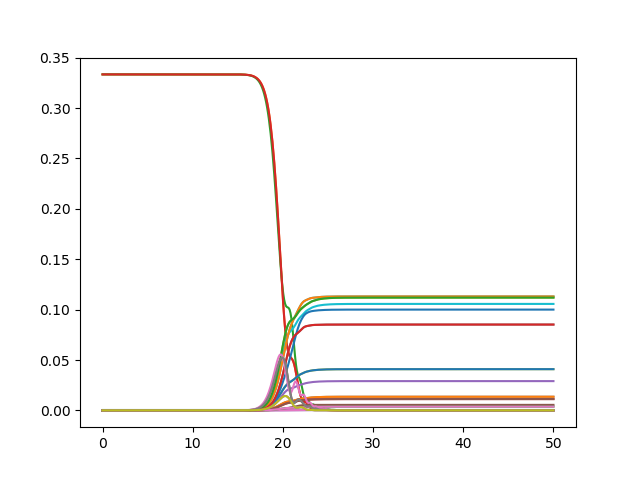

In [279]:
fig, ax = plt.subplots()
ax.plot(t_array*1e6, pop_results.T)

<IPython.core.display.Javascript object>


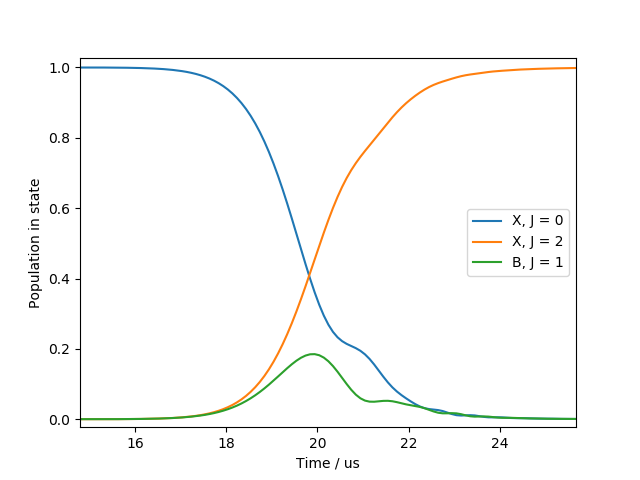

Text(0, 0.5, 'Population in state')

In [278]:
#Plot populations in different J
P0 = np.sum(pop_results[0:4,:], axis = 0)
P2 = np.sum(pop_results[4:24,:], axis = 0)
PB1 = np.sum(pop_results[24:,:], axis = 0)

fig, ax = plt.subplots()
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend()
ax.set_xlabel("Time / us")
ax.set_ylabel("Population in state")

## Speed tests

In [277]:
import timeit
from scipy.linalg import expm
L = L_t(T/2)*dt
timeit.timeit('M = expm(L*dt) @ rho_vec', number = 10, globals = globals())

2.0141026999917813

In [ ]:
from scipy.sparse import csc_matrix, csr_matrix 
from scipy.sparse.linalg import expm_multiply, expm


L_sparse = csc_matrix(L_t(T/2)*dt)

In [ ]:
timeit.timeit('L_sparse = csc_matrix(L*dt); M = expm_multiply(L_sparse,rho_vec)', number = 10, globals = globals())

In [ ]:
timeit.timeit('L_sparse = csc_matrix(L*dt); M = expm(L_sparse) @ rho_vec', number = 10, globals = globals())

In [ ]:
L_sparse

In [ ]:
dt